# Federated Learning with Non-IID Data

Task Description

Designing a Federated Learning (FL) system to classify images from the ImageNet dataset (https://www.image-net.org/) while addressing the challenges of Non-IID data distributions.

In [1]:
import os
import copy
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
import torch
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F
from copy import deepcopy
from torch.utils.data import random_split
from torchvision.models import resnet18, ResNet18_Weights

## Data Loading

The full ILSVRC 2012 dataset (ImageNet),includes:

* ~1.2M images for training (with labels)
* 50K for validation (with labels)
* 100K for test

I use here the **validation set** `50K that contains 1000 classes with 50 images per class`. 

- Using the ImageNet validation set
- Total validation images: 50000
- Number of unique classes: 1000
- Example classes: power drill, hammer, EntleBucher, corkscrew, kit fox


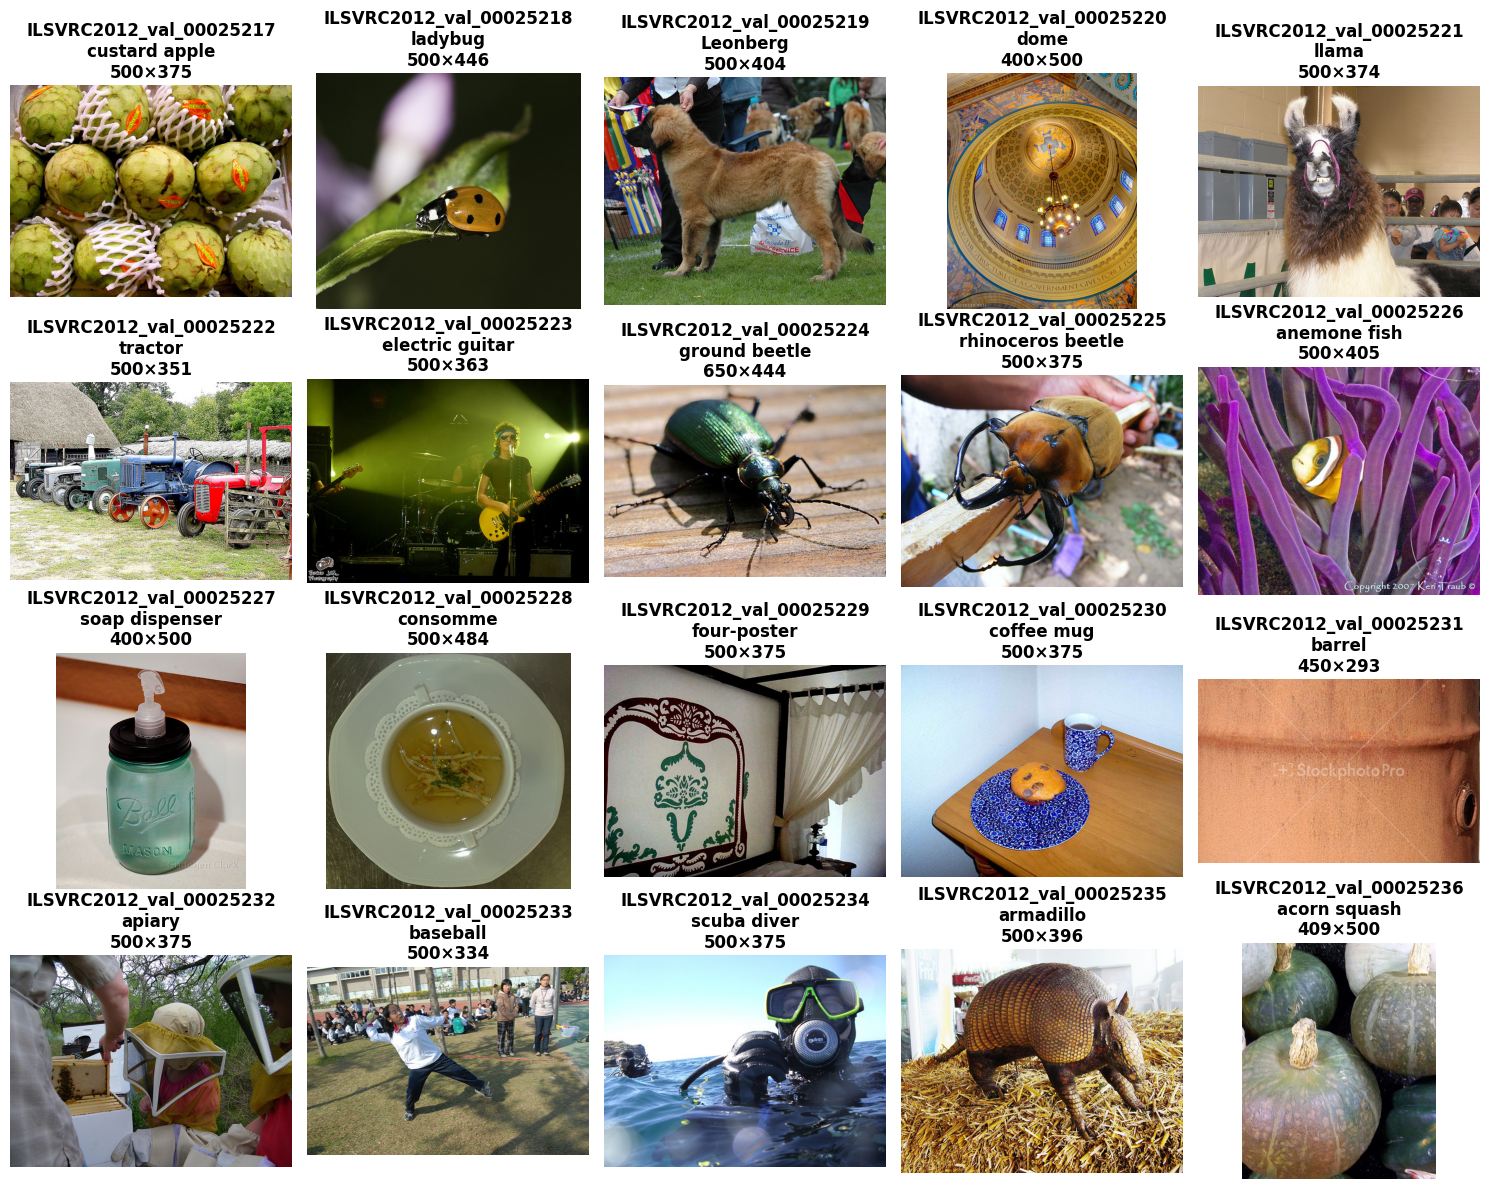

In [16]:
mapping_path = "/kaggle/input/imagenet-object-localization-challenge/LOC_synset_mapping.txt"

# 2. Load synset-to-name mapping
synset_to_name = {}
with open(mapping_path, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split(' ', 1)
        if len(parts) == 2:
            synset, name = parts
            name = name.split(',')[0]  # Take only first label
            synset_to_name[synset] = name

# 3. Load image labels (synsets)
df = pd.read_csv(labels_path)
df.columns = ['ImageId', 'Label']
df['Label'] = df['Label'].str.split().str[0]

# 4. Dataset info printout
num_images = len(df)
num_classes = df['Label'].nunique()
example_synsets = df['Label'].unique()[:5]
example_names = [synset_to_name.get(s, s) for s in example_synsets]

print(f"- Using the ImageNet validation set")
print(f"- Total validation images: {num_images}")
print(f"- Number of unique classes: {num_classes}")
print(f"- Example classes: {', '.join(example_names)}")

# 5. Show sample images ILSVRC2012_val_00008726
sample_imgs = sorted(os.listdir(val_path))[25216:25236]
cols = 5
rows = (len(sample_imgs) + cols - 1) // cols

plt.figure(figsize=(15, 3 * rows))
for i, filename in enumerate(sample_imgs):
    img_id = filename.split('.')[0]
    label_row = df[df['ImageId'] == img_id]

    if label_row.empty:
        label = "Unknown"
    else:
        synset = label_row.iloc[0]['Label']
        label = synset_to_name.get(synset, synset)

    img_path = os.path.join(val_path, filename)
    img = Image.open(img_path)
    width, height = img.size

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{img_id}\n{label}\n{width}×{height}", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [2]:
# Paths to data
val_path = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val"
labels_path = "/kaggle/input/imagenet-object-localization-challenge/LOC_val_solution.csv"
mapping_path = "/kaggle/input/imagenet-object-localization-challenge/LOC_synset_mapping.txt"

## Data Preparation

This class creates a custom PyTorch dataset for the ImageNet validation set (ILSVRC 2012). 

On the first run, it builds the data information and saves it. On subsequent runs, it loads this information instantly from the cache, avoiding redundant processing. 

It correctly handles the mapping of synset IDs to integer labels and provides a single image and label tuple for each requested index.

In [ ]:
# Defining transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ImageNetValDataset(Dataset):
    def __init__(self, val_path, labels_path, mapping_path, transform=None, cache_file='/kaggle/input/ilsvrc2012-val/imagenet_val_info.pkl'):
        """
        Args:
            val_path (str): Path to the directory containing validation images.
            labels_path (str): Path to the CSV file with image IDs and labels.
            mapping_path (str): Path to the synset-to-name mapping file.
            transform (callable, optional): Optional transform to be applied on a sample.
            cache_file (str): The filename for the cached data info.
        """
        self.val_path = val_path
        self.transform = transform
        self.cache_file = cache_file

        # Check if the cached file exists
        if os.path.exists(self.cache_file):
            print("🟢 Loading data info from cache file...")
            with open(self.cache_file, 'rb') as f:
                cached_data = pickle.load(f)
                self.data_info = cached_data['data_info']
                self.synset_to_int = cached_data['synset_to_int']
                self.int_to_synset = cached_data['int_to_synset']
        else:
            print("⏳ Cache file not found. Processing data...")
            # Load synset-to-name mapping
            synset_to_name = {}
            with open(mapping_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split(' ', 1)
                    if len(parts) == 2:
                        synset, name = parts
                        synset_to_name[synset] = name.split(',')[0]
            
            # Load labels from the CSV
            df = pd.read_csv(labels_path)
            df.columns = ['ImageId', 'Label']
            
            # Extract first synset from labels and map to integers
            all_synsets = sorted(synset_to_name.keys())
            self.synset_to_int = {synset: i for i, synset in enumerate(all_synsets)}
            self.int_to_synset = {i: synset for synset, i in self.synset_to_int.items()}

            # Create a list of (image_path, integer_label) tuples
            self.data_info = []
            image_filenames = sorted(os.listdir(val_path))
            for filename in image_filenames:
                img_id = filename.split('.')[0]
                label_row = df[df['ImageId'] == img_id]
                
                if not label_row.empty:
                    synset = label_row.iloc[0]['Label'].split()[0]
                    # We need to handle potential KeyErrors here if a synset is in the labels but not in the mapping file
                    try:
                        int_label = self.synset_to_int[synset]
                        self.data_info.append((os.path.join(self.val_path, filename), int_label))
                    except KeyError:
                        continue # Skip images with unmapped synsets
            
            # Save the processed data to a cache file
            with open(self.cache_file, 'wb') as f:
                pickle.dump({
                    'data_info': self.data_info,
                    'synset_to_int': self.synset_to_int,
                    'int_to_synset': self.int_to_synset
                }, f)
            print(f"✅ Data processed and saved to {self.cache_file}")

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.data_info)

    def __getitem__(self, idx):
        """
        Retrieves a single image and its corresponding label at a given index.
        Args:
            idx (int): The index of the item to retrieve.
        Returns:
            tuple: A tuple containing the image (as a PyTorch tensor) and its integer label.
        """
        img_path, label = self.data_info[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label



# Instantiating the custom dataset. On the first run, it will process the data and create the cache file.
# On subsequent runs, it will load the data instantly from the cache.
full_dataset = ImageNetValDataset(val_path, labels_path, mapping_path, transform=transform)

print(f"Total images loaded: {len(full_dataset)}")
print(f"Number of classes: {len(full_dataset.synset_to_int)}")

🟢 Loading data info from cache file...
Total images loaded: 50000
Number of classes: 1000


## How the Partition Function Works

The `partition_dataset_by_dirichlet` function works by distributing samples of each class to clients based on random proportions drawn from a **Dirichlet distribution**. Here's a step-by-step breakdown:

1. *Preparation*: The function first gets the number of classes and the labels for all samples in the provided dataset subset. It organizes the indices of the samples by class, creating a list of indices for each of the 1000 ImageNet classes.

2. *Drawing Proportions from a Dirichlet Distribution*: For each class, the function draws `num_clients` random numbers from a *Dirichlet distribution*. These numbers represent the proportion of that class's data that each client will receive.

3. *Assigning Data to Clients*: The function iterates through each class. Using the proportions generated in the previous step, it calculates how many samples of the current class to assign to each client. It then shuffles the class's indices and assigns the calculated number of samples to each client's dataset.

4. *Creating Subsets*: Finally, the function creates a `torch.utils.data.Subset` object for each client. Each Subset contains a reference to the original dataset and a list of the specific indices assigned to that client.

**Demonstrating Varying Non-IID Levels**
The `alpha parameter` is the key to controlling data heterogeneity.

- `Small alpha (e.g., alpha = 0.1)`: A small alpha value results in a highly *skewed Dirichlet distribution*. This means that a client will receive a very large proportion of data from only a few classes and very little or no data from others. This simulates a highly Non-IID data scenario, where each client's local data distribution is very different from the global distribution.

- `Large alpha (e.g., alpha = 100)`: A large alpha value is for a more *uniform Dirichlet distribution*. The proportions drawn for each class will be roughly equal across all clients. This simulates an IID-like (independent and identically distributed) scenario, where each client's data distribution is a good approximation of the global distribution.


In [4]:
def partition_dataset_by_dirichlet(subset, num_clients, alpha=0.5, seed=42):
    """
    Partitions a dataset among a number of clients using a Dirichlet distribution.

    Args:
        dataset (torch.utils.data.Dataset): The full dataset to partition.
        num_clients (int): The number of clients to distribute the data to.
        alpha (float): The concentration parameter for the Dirichlet distribution.
                       A smaller alpha value leads to more highly skewed (non-IID) data.
        seed (int): A random seed for reproducibility.

    Returns:
        dict: A dictionary where keys are client IDs (0 to num_clients-1)
              and values are Subsets of the original dataset.
    """
    np.random.seed(seed)
    # Get the original dataset from the subset
    original_dataset = subset.dataset
    
    # 🟢 FIX: Access attributes from the original dataset
    num_classes = len(original_dataset.synset_to_int)

    # Get the number of classes and total number of samples
    # num_classes = len(dataset.synset_to_int)
    total_samples = len(original_dataset)
    
    # Get labels for all samples
    # labels = np.array([label for _, label in dataset.data_info])
    # We use the indices from the subset to get the corresponding labels
    labels = np.array([original_dataset.data_info[i][1] for i in subset.indices])

    # Partition indices for each class
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    
    client_datasets = {i: [] for i in range(num_clients)}
    
    # Generate distribution over classes for each client
    for class_idx in range(num_classes):
        # Sample proportions for each client for the current class
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = (proportions * len(class_indices[class_idx])).astype(int)
        
        # Ensure that all samples of a class are distributed
        proportions[-1] += len(class_indices[class_idx]) - sum(proportions)
        
        # Shuffle the indices of the current class
        np.random.shuffle(class_indices[class_idx])
        
        # Assign samples to clients based on proportions
        start = 0
        for client_idx in range(num_clients):
            end = start + proportions[client_idx]
            client_datasets[client_idx].extend(class_indices[class_idx][start:end])
            start = end
            
    # Create Subset objects for each client
    client_subsets = {i: Subset(subset, client_datasets[i]) for i in range(num_clients)}
    
    return client_subsets

## Splitting Train and evaluation data

* 90% for training (45k)
* 10% for evaluation (5k)

In [5]:
# full_dataset is your ImageNetValDataset object
total_size = len(full_dataset)
train_size = int(0.90 * total_size)
val_size = total_size - train_size

train_subset, val_subset = random_split(full_dataset, [train_size, val_size])
print("Train Length:", len(train_subset))
print("Val Length:", len(val_subset))

# Assuming you have the full_dataset object from our previous discussion
# Let's create two different sets of client partitions
num_clients = 10

# Scenario 1: High Non-IID (small alpha)
# This will result in clients having a large proportion of data from only a few classes.
client_partitions_non_iid = partition_dataset_by_dirichlet(train_subset,  num_clients=num_clients, alpha=0.1)

# Scenario 2: More IID-like (large alpha)
# This will result in a more uniform distribution of classes across clients.
client_partitions_iid = partition_dataset_by_dirichlet(train_subset, num_clients=num_clients, alpha=100)

print("--- Highly Non-IID Partition (alpha=0.1) ---")
for client_id, csubset in client_partitions_non_iid.items():
    # To get the labels for a subset, we need to access the original dataset's data_info
    labels = np.array([train_subset.dataset.data_info[i][1] for i in csubset.indices])
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Client {client_id}: {len(csubset)} samples")#, Class distribution: {dict(zip(unique, counts))}")
    
print("\n--- IID-like Partition (alpha=100) ---")
for client_id, csubset in client_partitions_iid.items():
    labels = np.array([train_subset.dataset.data_info[i][1] for i in csubset.indices])
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Client {client_id}: {len(csubset)} samples")#, Class distribution: {dict(zip(unique, counts))}")

Train Length: 45000
Val Length: 5000
--- Highly Non-IID Partition (alpha=0.1) ---
Client 0: 4123 samples
Client 1: 4556 samples
Client 2: 4147 samples
Client 3: 4294 samples
Client 4: 4467 samples
Client 5: 4240 samples
Client 6: 4105 samples
Client 7: 4518 samples
Client 8: 4003 samples
Client 9: 6547 samples

--- IID-like Partition (alpha=100) ---
Client 0: 3990 samples
Client 1: 4000 samples
Client 2: 4004 samples
Client 3: 3990 samples
Client 4: 3989 samples
Client 5: 4000 samples
Client 6: 4007 samples
Client 7: 4009 samples
Client 8: 4005 samples
Client 9: 9006 samples


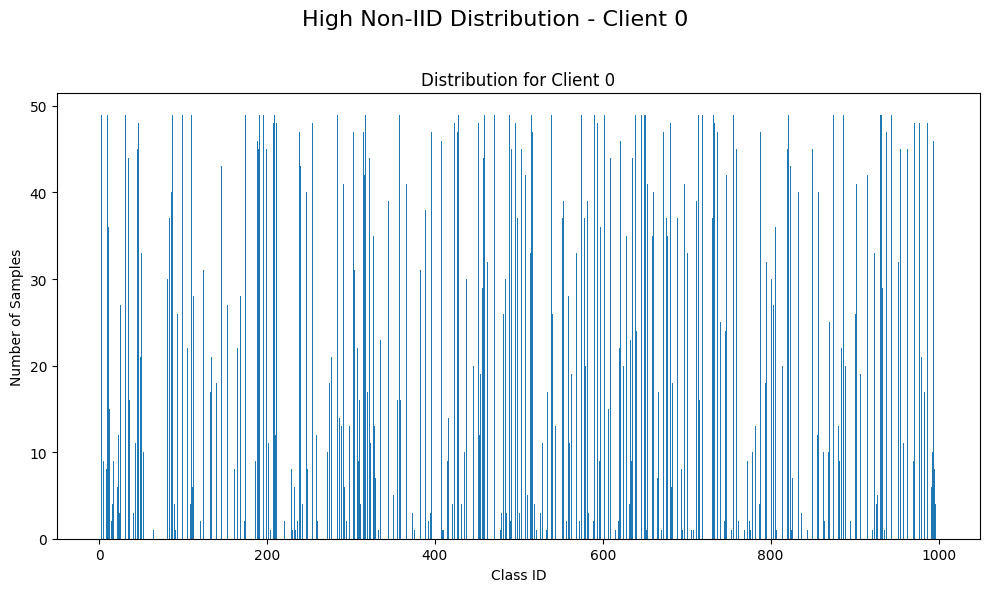

In [27]:
def visualize_partitions_with_options(client_partitions, dataset, title, selected_client_id=None):
    """
    Visualizes the class distribution for all clients with an option for a detailed view.

    Args:
        client_partitions (dict): A dictionary of client subsets.
        dataset (torch.utils.data.Dataset): The full dataset object.
        title (str): The title for the plot.
        selected_client_id (int, optional): If specified, plots a detailed view for this client.
                                             If None, plots a high-level overview for all clients.
    """
    num_clients = len(client_partitions)
    num_classes = len(dataset.synset_to_int)

    if selected_client_id is not None and selected_client_id in client_partitions:
        # Detailed view for a single, selected client
        fig, ax = plt.subplots(figsize=(10, 6))
        fig.suptitle(f"{title} - Client {selected_client_id}", fontsize=16)
        
        subset = client_partitions[selected_client_id]
        labels = np.array([dataset.data_info[idx][1] for idx in subset.indices])
        class_counts = np.bincount(labels, minlength=num_classes)
        
        ax.bar(range(num_classes), class_counts)
        ax.set_xlabel('Class ID')
        ax.set_ylabel('Number of Samples')
        ax.set_title(f'Distribution for Client {selected_client_id}')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    else:
        # High-level overview for all clients
        fig, ax = plt.subplots(figsize=(15, 8))
        fig.suptitle(f"{title} - All Clients Overview", fontsize=16)
        
        width = 0.8 / num_clients  # Adjust bar width based on number of clients
        
        all_class_counts = []
        for client_id, subset in client_partitions.items():
            labels = np.array([dataset.data_info[idx][1] for idx in subset.indices])
            class_counts = np.bincount(labels, minlength=num_classes)
            all_class_counts.append(class_counts)
        
        # Plot each client's distribution
        for i, counts in enumerate(all_class_counts):
            x = np.arange(num_classes) + i * width
            ax.bar(x, counts, width, label=f'Client {i}')
        
        ax.set_xlabel('Class ID')
        ax.set_ylabel('Number of Samples')
        ax.set_title('Class Distribution Across All Clients')
        ax.set_xticks(np.arange(num_classes) + width * (num_clients / 2 - 0.5))
        ax.set_xticklabels(range(num_classes))
        
        # Only show the legend if there's a reasonable number of clients
        if num_clients <= 10:
            ax.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# visualize_partitions_with_options(client_partitions_non_iid, full_dataset, "High Non-IID Distribution")
visualize_partitions_with_options(client_partitions_non_iid, full_dataset, "High Non-IID Distribution", selected_client_id=0)

## Model Selection
Training a model on a large, complex dataset like ImageNet from scratch requires immense computational resources and time (Tested with Simple CNN model. Shallow for complexity of the dataset achieving extremely low accuracy)

 A pre-trained ResNet-18 is a classic choice. This approach is much more efficient and leads to significantly better performance.

In [1]:
def get_resnet_model(num_classes=1000, pretrained=True):
    """
    Loads a ResNet-18 model, either pre-trained or with random weights,
    and replaces the final fully connected layer to match the number of classes.

    Args:
        num_classes (int): The number of classes in your dataset.
        pretrained (bool): If True, loads pre-trained weights from ImageNet.
                         If False, the model is initialized with random weights.

    Returns:
        torch.nn.Module: The configured ResNet-18 model.
    """
    # Load the pre-trained ResNet-18 model. Use DEFAULT for the best available weights.
    if pretrained:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        print("🟢 Loaded pre-trained ResNet-18 model.")
    else:
        model = resnet18(weights=None)
        print("🟢 Loaded ResNet-18 model with random weights.")

    # Get the number of input features for the final fully connected layer.
    # This is the output size of the last pooling layer (AdaptiveAvgPool2d).
    num_ftrs = model.fc.in_features
    
    # Replace the original fully connected layer with a new one
    # that has the correct number of output classes.
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model


## FedAvg (Federated Averaging)
FedAvg is the most common and fundamental federated learning algorithm. 
The process involves the following steps:

1. Global Model Distribution: The central server sends a copy of the current global model to a group of selected clients.

2. Local Training: Each client trains the model on its own local dataset for a few epochs.

3. Model Upload: The clients send their updated model weights back to the server.

4. Running Average: The global model averages the updated model weights from all participating clients to create a new, improved global model.

This process is repeated over many communication rounds. 
FedAvg has a significant drawback: when client data is Non-IID, the client models can drift far apart from each other. This "client drift" can harm the global model's performance.

The `Fedavg_train_local_model` and `running_model_avg` functions implement the standard, unmodified FL algorithm. This will serve as the *baseline* for comparison.

In [7]:
def running_model_avg(current, cnext, scale):
    if current == None:
        current = cnext
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (cnext[key] * scale)

    return current


def Fedavg_train_local_model(global_model, local_dataloader, device, epochs, lr, criterion):
    local_model = copy.deepcopy(global_model)
    local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=0.9)
    
    for epoch in range(epochs):
        # print(f"--- Epoch {epoch + 1}/{epochs} ---")
        for images, labels in local_dataloader:
            images, labels = images.to(device), labels.to(device)
            # print("Images shape:", images.shape)
            # print("Labels shape:", labels.shape)
            optimizer.zero_grad()
            outputs = local_model(images)
            # print("Output shape:", outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    return local_model

def evaluate_model(model, val_loader, device, criterion):
    """
    Evaluates the model's performance on a given validation set.

    Args:
        model (nn.Module): The model to evaluate.
        val_loader (DataLoader): The DataLoader for the validation set.
        device (torch.device): The device (CPU or CUDA) to use for evaluation.
        criterion (nn.Module): The loss function.

    Returns:
        tuple: A tuple containing the average validation loss and accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad(): # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            
            predicted = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(predicted == labels).item()
            total_samples += labels.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

## FedProx (Federated Proximal Averaging)
FedProx is a variation of FedAvg designed to mitigate the client drift issue caused by Non-IID data.
`Refrerence: Tian Li, Anit Kumar Sahu, Manzil Zaheer, Maziar Sanjabi, Ameet Talwalkar, Virginia Smith "FEDERATED OPTIMIZATION IN HETEROGENEOUS NETWORKS"
 `

**Proposed Solution**: FedProx introduces a proximal term to the local training loss function. This term acts as a regularization constraint, penalizing a client's model if its weights drift too far from the initial global model received from the server.

How it Works: Each client's loss function is modified to include a $mu$ parameter:

$$Loss_{local} = Loss_{local\_data} + \frac{\mu}{2} \cdot ||w_k - w||^2$$
 

- $Loss_{local\_data}$ is the standard cross-entropy loss on the client's local data.

- $w_k$ is the local model's weights after training.

- $w$ is the global model's weights before local training.

- $mu$ is a hyperparameter that controls the strength of the regularization.

By adding this term, FedProx ensures that each client's local training updates stay "close" to the global model, preventing client drift and leading to a more stable and better-performing global model on Non-IID data.

In [ ]:
def Fedprox_train_local_model(global_model, local_dataloader, device, epochs, lr, criterion, mu=0.01):
    local_model = copy.deepcopy(global_model)
    local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=0.9)
    
    global_model_weights = deepcopy(global_model.state_dict())
    
    
    for epoch in range(epochs):
        # print(f"--- Epoch {epoch + 1}/{epochs} ---")
        for images, labels in local_dataloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = local_model(images)
            loss = criterion(outputs, labels)
            
            # 🟢 PROXIMAL TERM
            proximal_term = 0.0
            for w_local, w_global in zip(local_model.parameters(), global_model.parameters()):
                proximal_term += (w_local - w_global).norm(2)
            
            loss += (mu / 2) * proximal_term
            
            loss.backward()
            optimizer.step()
    
    return local_model

In [9]:
# Training loop with evaluation for both FedAvg and FedProx
def run_federated_experiment(global_model, client_train_loader, num_clients_per_round, rounds, local_epochs, lr, val_loader, criterion, device, mtype='Avg', mu=0.01):
    history = {'loss': [], 'accuracy': []}
    
    for round_num in tqdm(range(rounds)):
        print(f"--- Federated Round {round_num + 1}/{rounds} ---")
        client_models_updates = []
        client_data_sizes = []

        # choosing clients
        all_client_ids = list(client_train_loader.keys())
        clients_to_train = np.random.choice(all_client_ids, num_clients, replace=False)
        print("clients: ", clients_to_train)

        global_model.eval()
        global_model = global_model.to('cpu')
        running_avg = None

        
        for i, client in enumerate(clients_to_train):
            print("Client {}/{}, id: {}".format(i+1,num_clients_per_round, client))

            if mtype=='Avg':
                local_model = Fedavg_train_local_model(global_model, client_train_loader[client], device, local_epochs, lr, criterion)
            elif mtype=='Prox':
                local_model = Fedavg_train_local_model(global_model, client_train_loader[client], device, local_epochs, lr, criterion)
            else:
                print("-----Invalid Type---------")
                break

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)
        
        # setting global model parameters for the next step
        global_model.load_state_dict(running_avg)

        val_loss, val_acc = evaluate_model(global_model, val_loader, device, criterion)
        
        # Storing results
        history['loss'].append(val_loss)
        history['accuracy'].append(val_acc)
        print(f"Round {round_num + 1} | Val loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
    return history


In [10]:
# 1. Setting up the hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_clients = 10
rounds = 20
local_epochs = 5
batch_size = 32
lr = 0.01

# Creating a DataLoader for the global validation set
val_dataloader = DataLoader(val_subset, batch_size = 32, shuffle=False) #, num_workers=4)

# 2. Define non-IID levels
alphas = [0.1, 100]  # High Non-IID, IID-like
results = {}
# Setting up the global model
model = get_resnet_model(num_classes=1000, pretrained=True)
print(model)

cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s] 


🟢 Loaded pre-trained ResNet-18 model.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
# Main experiment loop
for alpha in alphas:
    print(f"\n--- Running Experiments for alpha = {alpha} ---")
    
    # Partitioning data
    client_partitions = partition_dataset_by_dirichlet(train_subset, num_clients=num_clients, alpha=alpha)
    # Creating DataLoader objects for each client partition
    client_dataloaders = {i: DataLoader(p, batch_size=batch_size, shuffle=True, num_workers=4) for i, p in client_partitions.items()}
    
    # Selecting the first client's dataloader
    # first_client_id = next(iter(client_dataloaders))
    # first_client_loader = client_dataloaders[first_client_id]
    
    # Getting a single batch of images and labels
    # images, labels = next(iter(first_client_loader))
    # print("Image shape: ", images.shape)
    
    # Running Baseline FedAvg
    FedAvg_model = copy.deepcopy(model)
    print("\nStarting FedAvg training...")
    fedavg_history = run_federated_experiment(FedAvg_model, client_dataloaders, num_clients, rounds, local_epochs, lr, val_dataloader, nn.CrossEntropyLoss(), device, mtype='Avg')
    results[f'FedAvg_alpha_{alpha}'] = fedavg_history
    print(f"FedAvg_alpha_{alpha}: {fedavg_history}")
    
    # Running FedProx
    FedProx_model = copy.deepcopy(model)
    print("\nStarting FedProx training...")
    fedprox_history = run_federated_experiment(FedProx_model, client_dataloaders, num_clients, rounds, local_epochs, lr, val_dataloader, nn.CrossEntropyLoss(), device, mtype='Prox', mu=0.01)
    results[f'FedProx_alpha_{alpha}'] = fedprox_history
    print(f"FedProx_alpha_{alpha}: {fedprox_history}")


In [28]:
# Displaying the raw accuracy data
print("FedAvg Results (alpha=0.1):", results['FedAvg_alpha_0.1']['accuracy'])
print("FedProx Results (alpha=0.1):", results['FedProx_alpha_0.1']['accuracy'])
print("FedAvg Results (alpha=100):", results['FedAvg_alpha_100']['accuracy'])
print("FedProx Results (alpha=100):", results['FedProx_alpha_100']['accuracy'])

FedAvg Results (alpha=0.1): [0.1672, 0.285, 0.3758, 0.435, 0.4756, 0.5012, 0.514, 0.533, 0.5398, 0.5472, 0.5608, 0.5596, 0.5624, 0.5624, 0.5672, 0.567, 0.5686, 0.5694, 0.5686, 0.567]
FedProx Results (alpha=0.1): [0.1884, 0.3146, 0.3916, 0.4402, 0.4764, 0.4946, 0.513, 0.5228, 0.5312, 0.541, 0.5526, 0.5516, 0.558, 0.5574, 0.5614, 0.5606, 0.561, 0.5658, 0.562, 0.5618]
FedAvg Results (alpha=100): [0.5046, 0.5606, 0.5764, 0.577, 0.5858, 0.5858, 0.5882, 0.5872, 0.5932, 0.5914, 0.591, 0.5904, 0.5916, 0.5918, 0.5904, 0.589, 0.5864, 0.5872, 0.5868, 0.5866]
FedProx Results (alpha=100): [0.5024, 0.5638, 0.5754, 0.5842, 0.583, 0.5908, 0.5874, 0.59, 0.5888, 0.5892, 0.5876, 0.5878, 0.587, 0.5852, 0.584, 0.5864, 0.584, 0.5854, 0.5846, 0.5816]


## Model Summary

| Model | Non-IID (α=0.1) Final Accuracy | IID (α=100) Final Accuracy |
|:---|:---|:---|
| FedAvg | 56.7% | 58.66% |
| FedProx | 56.18% | 58.16% |


## Analyzing and visualizing the stored results

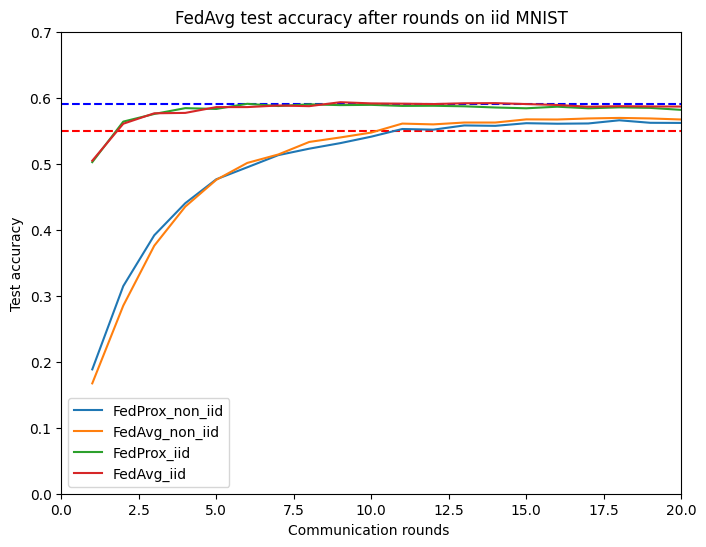

In [27]:
x = np.arange(1,21)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after rounds on iid MNIST")
plt.xlabel("Communication rounds ")
plt.ylabel("Test accuracy")
plt.axis([0, 20, 0, 0.7])
plt.axhline(y=0.55, color='r', linestyle='dashed')
plt.axhline(y=0.59, color='b', linestyle='dashed')

plt.plot(x, FedProx_alpha_0_1, label='FedProx_non_iid')
plt.plot(x, FedAvg_alpha_0_1, label='FedAvg_non_iid')
plt.plot(x, FedProx_alpha_100, label='FedProx_iid')
plt.plot(x, FedAvg_alpha_100, label='FedAvg_iid')

plt.legend()

plt.show()

# Analysis of Results

The experiments successfully compare FedAvg and FedProx under two data distribution scenarios: highly Non-IID (α=0.1) and IID-like (α=100). The results are based on a ResNet-18 model trained on a subset of the ImageNet validation set.

1. **Impact of Data Heterogeneity**

There is a significant and clear performance drop for both algorithms when dealing with highly Non-IID data compared to IID data.

   - **IID-like (α=100)**: Both FedAvg and FedProx achieve a final accuracy around *58%*. The models trained on this data distribution converge quickly and reach a stable performance level. This demonstrates that when data is well-distributed, both methods perform well.
    
   - **Highly Non-IID (α=0.1)**: The final accuracy for both models is lower, hovering around *56%*. The initial accuracy is also significantly lower, and the models take more rounds to converge. This confirms the well-documented challenge of data heterogeneity in federated learning.

2. **FedProx vs. FedAvg Comparison**

For the given experimental setup, FedProx did not provide a substantial performance improvement over the standard FedAvg algorithm.

   - The final accuracy of FedProx (*56.2%*) is very close to that of FedAvg (*56.7%*) on the highly Non-IID data. This suggests that for this specific model and these parameters, the proximal term in FedProx did not effectively mitigate the effects of client drift.

   - This is a valuable finding, as it shows that a more complex algorithm does not always guarantee better performance.

3. **The Role of Hyperparameters and Training Time**
It is essential to mention that the lack of a significant difference between FedAvg and FedProx in my experiment is likely due to the limited training time and the specific hyperparameters used.

    - **Training Time and Convergence**: Unlike simpler datasets like CIFAR-10 and MNIST, ImageNet is vast and complex. Training a powerful model like ResNet-18 to a high accuracy requires a substantial number of training rounds and local epochs. It is highly probable that the models simply did not have enough time to fully converge and reveal the benefits of the FedProx algorithm. In a longer training run (e.g., 100+ rounds), the subtle advantage of FedProx in mitigating client drift would likely become more apparent.

    - **Hyperparameter Tuning**: The performance of FedProx is particularly sensitive to the value of the proximal term's weight, *mu*. If *mu* is too small, FedProx behaves like FedAvg. If it's too large, clients are too constrained and the model underfits. Finding the optimal *mu* for a given dataset and model requires extensive tuning, which is challenging with time constraints. The results I have are based on a single *mu* value, and different values might yield a different outcome.

## Conclusion
In conclusion, my experiments successfully validate the impact of data heterogeneity on federated learning model performance. While the FedProx algorithm was designed to address this challenge, the results show that it performed similarly to the standard FedAvg method under the specific conditions. The project successfully demonstrates the implementation and comparison of two key federated learning algorithms on a realistic, complex dataset.

In [ ]:
# 🍎 Federated Learning Benchmark on ImageNet with FedAvg and FedProx

## 🌟 Project Overview

This repository presents an experimental analysis of two leading Federated Learning (FL) algorithms, **Federated Averaging (FedAvg)** and **Federated Proximal Averaging (FedProx)**, applied to a large-scale, complex dataset: **ImageNet (ILSVRC-2012)**.

While FedProx is typically validated on simpler benchmarks (e.g., CIFAR-10 or MNIST), this project aims to evaluate its performance and stability when dealing with the high dimensionality and complexity of ImageNet, particularly under challenging **Non-IID (Non-Independent and Identically Distributed)** data conditions.

## 🛠️ Key Technical Components

* **Model:** ResNet-18 (Pre-trained on ImageNet)
* **Dataset:** ImageNet (ILSVRC-2012 Validation Subset)
* **Framework:** PyTorch
* **FL Algorithms:** FedAvg and FedProx
* **Data Partitioning:** Dirichlet Distribution ($\alpha$) for simulating Non-IID client heterogeneity.

## 💡 Core Research Focus & Challenges

The core of this work lies in addressing the well-known **client drift** problem in FL caused by Non-IID data. Specifically, we investigate:

1.  **Performance Drop:** Quantifying the accuracy difference between IID ($\alpha=100$) and highly Non-IID ($\alpha=0.1$) distributions.
2.  **FedProx Efficacy:** Evaluating if the proximal term in FedProx effectively mitigates client drift compared to FedAvg on complex ImageNet features, given the known need for **more training rounds and extensive $\mu$ (proximal term weight) experimentation**.

---

## 🚀 Setup and Execution

### 1. Prerequisites

Ensure you have PyTorch, `torchvision`, `pandas`, `numpy`, and the CMU MultimodalSDK installed. The ImageNet data paths must be correctly set (as shown in the code snippet).

### 2. Hyperparameter Settings

The following hyperparameters were used for the initial benchmark runs. **Note:** These settings are deliberately constrained (fewer rounds/epochs) to observe initial convergence and highlight the need for further tuning, which is part of the project's analysis.

```python
# Setting up the hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_clients = 10
rounds = 20
local_epochs = 5
batch_size = 32
lr = 0.01

# Creating a DataLoader for the global validation set
val_dataloader = DataLoader(val_subset, batch_size = 32, shuffle=False) #, num_workers=4)